# Calculations of supercurrents in a proximitized semiconducting 3D nanowire
The simulations in this notebook generate data that is used for the plotting of the theoretical figures of the paper.

Some simulations are expensive and take ~20hrs on 300 cores. Therefore we often cut up the simulation in parts using the `funcs.run_simulation` function with the `N` argument. The resulting (partial) data is saved in `pandas.DataFrame`s.

To view the resulting data (after joining the parts with `funcs.combine_dfs`, see example just below) see [paper-figures.ipynb](paper-figures.ipynb) for the figures from the paper or [explore-data.ipynb](explore-data.ipynb) to interactively explore the data using sliders.

### Example: joining the data files
```python
# If the simulation is run with:
funcs.run_simulation(lview, func, vals, parameters=dict(**params, **syst_pars),
                     fname_i='tmp/1d_alpha_vs_B_x_{}.hdf', N=20000, overwrite=True)
# You can join the resulting files with:
df = funcs.combine_dfs('tmp/1d_alpha_vs_B_x_*.hdf', 'data/1d_alpha_vs_B_x.hdf')
```

# The Python conda environment that is used
* We used the following Python environment. See [README.md](README.md) for installation instructions.
```yaml
name: python3
channels:
  - conda-forge
dependencies:
  - python=3.6
  - kwant=1.3
  - holoviews=1.8.1
  - xarray=0.9.6
  - pandas=0.20.3
  - pytables=3.4.2
  - toolz=0.8.2
  - hpc05  # This is only needed if you use a PBS cluster with headnode, as on the TU Delft network
```

## Notes
* See [example-toy-models.ipynb](example-toy-models.ipynb) for simpler examples.
* Read the comments!

In [1]:
# Connect the ipyparallel.Client
try:
    # If this can be imported, it assumes you have access to a PBS cluster
    # with a headnode where you started a cluster
    import hpc05
    client = hpc05.Client(profile='pbs', timeout=60)
    print("Connected to hpc05")
except ImportError:
    # Otherwise start an ipyparallel ipcluster locally
    from ipyparallel import Client
    client = Client()
    print("Connected to local engines")

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


OSError: Connection file '~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

In [3]:
dview = client[:]
dview.use_dill()
lview = client.load_balanced_view()
print('Connected to {} engines.'.format(len(dview)))

NameError: name 'client' is not defined

In [1]:
# Make sure this folder is in your $PYTHONPATH of the ipengines
# or set the correct location in the next line (run after all engines are connected)
%px import sys, os; sys.path.append(os.path.expanduser('~/Work/nanowire_current/'))

UsageError: Line magic function `%px` not found.


# Imports

In [2]:
# Related third party imports
import holoviews as hv
import kwant
import numpy as np
import pandas as pd

# Local imports
import funcs

%matplotlib inline
hv.notebook_extension()

# Creating some wires as example

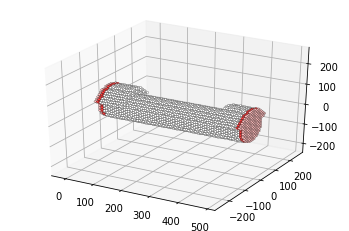

In [5]:
# Create system with infinite leads
syst_pars = dict(a=8, angle=0, site_disorder=False, holes=True, L=320, L_sc=80,
                 phi=135, r1=60, r2=90, shape='circle', with_leads=True,
                 with_shell=True, with_vlead=True)

syst, hopping = funcs.make_3d_wire(**syst_pars)
kwant.plot(syst);

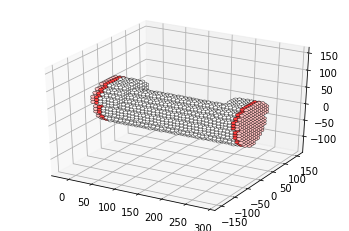

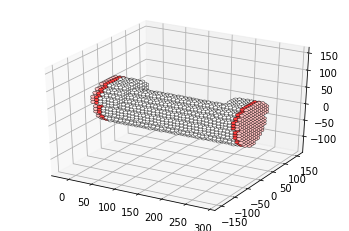

In [13]:
# Create system without leads and bigger SC regions
syst_pars['L_sc'] = 40
syst_pars['L'] = 200
syst, hopping = funcs.make_3d_wire(**syst_pars)
kwant.plot(syst)#, site_size=0, hop_lw=0.1);

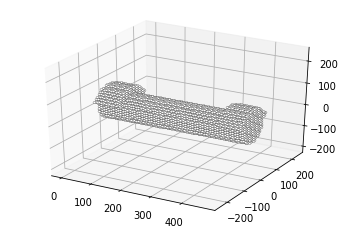

In [6]:
# Create system without leads
syst_pars['with_leads'] = False
syst, hopping = funcs.make_3d_wire(**syst_pars)
kwant.plot(syst);

# Mean free path calculation
See [mean-free-path.ipynb](mean-free-path.ipynb) for the data processing.

In [18]:
syst_pars = dict(a=8, angle=0, site_disorder=True, holes=False, L_sc=8,
                 phi=135, r1=50, r2=70, shape='circle', with_leads=True,
                 with_shell=False, with_vlead=False)

params = dict(alpha=20, B_x=0, B_y=0, B_z=0, Delta=0, g=50,
              orbital=True, V='lambda x: 0', **funcs.constants.__dict__)

Ls = np.arange(80, 2000, 80)
salts = np.arange(0, 10)
disorders = [0, 10, 20, 30, 40, 50, 55, 60, 65, 70, 75, 80, 90, 100, 110]
mus = np.arange(10, 31)

vals = funcs.named_product(salt=salts, disorder=disorders, L=Ls, mu=mus)
print(len(vals))

def func(val, syst_pars=syst_pars, params=params):
    import kwant, funcs
    
    # Combine the fixed parameters `params` and the changing
    # parameters `val` to one dict and evaluate the string
    # lambda functions.
    params = funcs.parse_params(dict(**params, **val))
    
    # Remove the parameters from `params` that belong in `syst_pars`.
    for x in ['L']:
        syst_pars[x] = params.pop(x)

    syst, hopping = funcs.make_3d_wire(**syst_pars)
    smatrix = kwant.smatrix(syst, params=params)
    
    # Return a combined dictionary with the results and input.
    return dict(transmission=smatrix.transmission(0, 1),
                num_propagating=smatrix.num_propagating(0),
                **val)


75600


In [19]:
fname = '/home/bomin/Desktop/1706/code/QPCsupercurrent/data/mean_free_path.hdf'

In [41]:
def check_name(fname_i):
    fname = fname_i #.replace('{_}', '{a}') #.format(i)
    print((fname))

In [42]:
check_name(fname)

/home/bomin/Desktop/1706/code/QPCsupercurrent/data/mean_free_path.hdf


In [43]:
funcs.run_simulation(func, vals, dict(**params, **syst_pars), fname, overwrite=True)

TypeError: run_simulation() missing 1 required positional argument: 'fname_i'

# $B_x(I_c)$ combinations of effects and geometries:

In [18]:
syst_pars = dict(a=8, angle=0, site_disorder=False, holes=True, phi=135,
                 r1=50, r2=70, shape='circle', with_shell=True, with_vlead=True)

params = dict(B_y=0, B_z=0, Delta=60, c_tunnel=5/8, V=lambda x: 0, **funcs.constants.__dict__)

Ts = [0.1, 0.5, 1]
orbital_bools = [False, True]
gs = [0, 50]
alphas = [0, 20]
mus = [10, 15, 20, 25, 30]
Ls = [80, 160, 320, 640]
leads = [(True, 8), (False, 400)]
Bs = np.linspace(0, 2, 101)

vals = funcs.named_product(T=Ts, L=Ls, orbital=orbital_bools,
                           g=gs, alpha=alphas, mu=mus, leads=leads, B_x=Bs)

def func(val, syst_pars=syst_pars, params=params):
    import funcs
    val['with_leads'], val['L_sc'] = val['leads']

    # Combine the fixed parameters `params` and the changing
    # parameters `val` to one dict and evaluate the string
    # lambda functions.
    params = funcs.parse_params(dict(**params, **val))

    # Remove the parameters from `params` that belong in `syst_pars`.
    for x in ['with_leads', 'L_sc', 'L']:
        syst_pars[x] = params.pop(x)

    syst, hopping = funcs.make_3d_wire(**syst_pars)

    # Return a combined dictionary with the results and input.
    return dict(**funcs.I_c(syst, hopping, params), **val)

fname = "tmp/I_c(B_x)_no_disorder_combinations_of_effects_and_geometries_{}.hdf"
funcs.run_simulation(lview, func, vals, dict(**params, **syst_pars), fname, 2000)


NameError: name 'lview' is not defined

# $B_x(I_c)$ with disorder:
* Main paper figure 4
* Supplementary materials figure 8

In [19]:
ONLY_PAPER_COMBINATIONS = False

syst_pars = dict(a=8, angle=0, site_disorder=True, holes=True, L=640,
                 L_sc=8, phi=135, r1=50, r2=70, shape='circle',
                 with_leads=True, with_shell=True, with_vlead=True)

params = dict(B_y=0, B_z=0, Delta=60, c_tunnel=5/8, V='lambda x: 0', T=100e-3, **funcs.constants.__dict__)

Bs = np.linspace(0, 0.5, 201)

if ONLY_PAPER_COMBINATIONS:
    # These are all the combinations of effects that are showed in Fig. 4 of the main paper.
    vals = [[(0, 0, True, 50, 20, 10, B),
             (0, 0, False, 50, 20, 10, B),
             (0, 0, True, 50, 0, 10, B),
             (0, 0, False, 50, 0, 10, B),
             (0, 0, True, 50, 20, 20, B),
             (0, 0, False, 50, 20, 20, B),
             (0, 0, True, 50, 0, 20, B),
             (0, 0, False, 50, 0, 20, B),
             (7, 75, True, 50, 20, 20, B)]
            for B in Bs]
    vals = sum(vals, [])
    names = ['salt', 'disorder', 'orbital', 'g', 'alphas', 'mu', 'B_x']
    vals = [dict(zip(names, val)) for val in vals]

else:
    # Calculate all combinations of effects (which is much slower.)
    vals = funcs.named_product(salt=np.arange(0, 8, 1), disorder=[0, 75], 
                               orbital=[False, True], g=[0, 50], alpha=[0, 20],
                               mu=[10, 20], B_x=Bs)

    # Filter out different salts when there is no disorder.
    vals = [val for val in vals if not (val['salt'] > 0 and val['disorder'] == 0)]

print(len(vals))

def func(val, syst_pars=syst_pars, params=params):
    import funcs
    syst, hopping = funcs.make_3d_wire(**syst_pars)
    
    # Combine the fixed parameters `params` and the changing
    # parameters `val` to one dict and evaluate the string
    # lambda functions.
    params = funcs.parse_params(dict(**params, **val))
    
    # Return a combined dictionary with the results and input.
    return dict(**funcs.I_c(syst, hopping, params), **val)

fname_i = "tmp/I_c(B_x)_mu10,20meV_disorder0,75meV_T0.1K_all_combinations_of_effects_{}.hdf"
funcs.run_simulation(lview, func, vals, dict(**params, **syst_pars), fname_i, 2500)

28944


NameError: name 'lview' is not defined

# Rotation of the magnetic field in the $xy$-plane
* Supplementary materials figure 10

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/3D_Spherical.svg/200px-3D_Spherical.svg.png)

In [20]:
syst_pars = dict(a=8, angle=0, site_disorder=True, holes=True, L=160, L_sc=8,
                 phi=135, r1=50, r2=70, shape='circle',
                 with_leads=True, with_shell=True, with_vlead=True)

params = dict(alpha=20, B_z=0, Delta=60, g=50, mu=20, salt=7,
              orbital=True, c_tunnel=5/8, V='lambda x: 0', T=100e-3, **funcs.constants.__dict__)

Bs = np.linspace(0, 2, 101)
thetas = [0, 45, 90]
vals = funcs.named_product(B=Bs, theta=thetas, disorder=[0, 75])

def func(val, syst_pars=syst_pars, params=params):
    import funcs
    import numpy as np
    angle = np.deg2rad(val['theta'])
    val['B_x'] = val['B'] * np.cos(angle).round(15)
    val['B_y'] = val['B'] * np.sin(angle).round(15)
    
    # Combine the fixed parameters `params` and the changing
    # parameters `val` to one dict and evaluate the string
    # lambda functions.
    params = funcs.parse_params(dict(**params, **val))

    syst, hopping = funcs.make_3d_wire(**syst_pars)

    # Return a combined dictionary with the results and input.
    return dict(**funcs.I_c(syst, hopping, params), **val)

fname = 'data/I_c(B_x)_mu20meV_rotation_of_field_in_xy_plane.hdf'
funcs.run_simulation(lview, func, vals, dict(**syst_pars, **params), fname, None, overwrite=True)

NameError: name 'lview' is not defined

# Tuning the induced gap

In [21]:
syst_pars = dict(a=8, angle=0, site_disorder=False, holes=True,
                 L=80, L_sc=8, phi=135, r1=50, r2=70, shape='circle',
                 with_leads=True, with_shell=True, with_vlead=False)

params = dict(alpha=20, B_x=0, B_y=0, B_z=0, g=50, orbital=True,
              c_tunnel=5/8, V='lambda x: 0', **funcs.constants.__dict__,)

mus = np.linspace(2, 30, 50)
Deltas = np.linspace(0, 100, 50)

vals = funcs.named_product(Delta=Deltas, mu=mus)

def func(val, syst_pars=syst_pars, params=params):
    import funcs
    import numpy as np
    lead = funcs.make_3d_wire(**syst_pars)[0].leads[1]

    # Combine the fixed parameters `params` and the changing
    # parameters `val` to one dict and evaluate the string
    # lambda functions.
    params = funcs.parse_params(dict(**params, **val))

    # Create the Hamiltonian `ham` at k=0.
    h0 = lead.cell_hamiltonian(params=params)
    t0 = lead.inter_cell_hopping(params=params)
    ham = h0 + t0 + t0.conj().T

    # Find the energies.
    ev = np.linalg.eigvalsh(ham)
    
    # Return a combined dictionary with the results and input.
    return dict(E_min=np.abs(ev).min(), **val)

funcs.run_simulation(lview, func, vals, dict(**params, **syst_pars), 'data/gap_tuning.hdf')

NameError: name 'lview' is not defined

In [22]:
# Plot the gaps and find the `Delta` that is needed for the required `Delta_induced`.
df = pd.read_hdf('data/gap_tuning.hdf')
Deltas = sorted(df.Delta.unique())
mus = sorted(df.mu.unique())
gap = np.reshape(df.E_min.values, (len(Deltas), len(mus))) 
max_gap = np.max(np.min(gap, axis=1))
print("Max gap is {} meV".format(max_gap))

FileNotFoundError: File data/gap_tuning.hdf does not exist

In [23]:
hv.Curve((Deltas, gap.min(axis=1)), kdims=[r'$\Delta$'], vdims=[r'$E_{gap}$'],
         label=r"$E_{gap}$ over range of $\Delta$'s")

NameError: name 'gap' is not defined

In [24]:
Delta_ind = {delta: hv.Path((mus, evs), kdims=[r'$\mu$', ('E_gap', r'$E_{gap}$')]) 
      for evs, delta in zip(gap, Deltas)}

hm = hv.HoloMap(Delta_ind, kdims=[r'$\Delta$'])
(hm.select(E_gap=(0.15, 0.40)) * hv.HLine(0.25))

NameError: name 'gap' is not defined

## Gate simulation with and without disorder $I_c(B_x, V)$
* Main paper figure 5(b)
* Supplementary materials figure 9

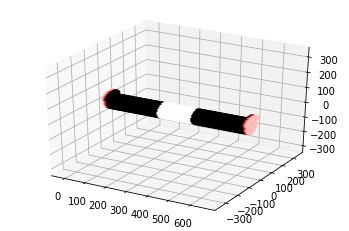

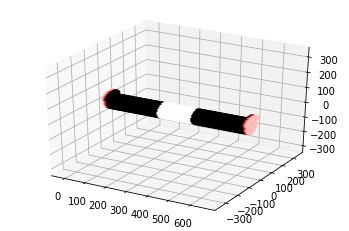

In [25]:
# Plot test
syst_pars = dict(a=8, angle=0, site_disorder=False, holes=True,
                 L=640, L_sc=8, phi=135, r1=50, r2=70, shape='circle',
                 with_leads=True, with_shell=True, with_vlead=True)

syst, hopping = funcs.make_3d_wire(**syst_pars)
gate_fun = funcs.gate(syst, 100, 160)
sites = [gate_fun(pos[0]) for pos in [i.pos for i in syst.sites]]
kwant.plot(syst, site_lw=0, site_color=sites, colorbar=False)

In [26]:
syst_pars = dict(a=8, angle=0, site_disorder=True, holes=True,
                 L=640, L_sc=8, phi=135, r1=50, r2=70, shape='circle',
                 with_leads=True, with_shell=True, with_vlead=True)

params = dict(alpha=20, B_y=0, B_z=0, Delta=60, g=50, mu=20, orbital=True,
              c_tunnel=5/8, salt=7, T=100e-3, **funcs.constants.__dict__)

Bs = np.linspace(0, 0.5, 51)
Vs = np.linspace(0, 10, 51)
gate_sizes = [160]
disorders = [0, 75]

vals = funcs.named_product(gate_size=gate_sizes,
                           disorder=disorders, V=Vs, B_x=Bs)

def func(val, syst_pars=syst_pars, params=params):
    import funcs
    syst, hopping = funcs.make_3d_wire(**syst_pars)

    # Combine the fixed parameters `params` and the changing
    # parameters `val` to one dict and evaluate the string
    # lambda functions.
    params = funcs.parse_params(dict(**params, **val))

    # Create a potential function for the gate.
    params['V'] = funcs.gate(syst, params['V'], params['gate_size'])

    # Return a combined dictionary with the results and input.
    return dict(**funcs.I_c(syst, hopping, params), **val)

fname = "tmp/I_c(B_x,_V)_gate160nm_mu20meV_disorder0,75meV_T0.1K_{}.hdf"
funcs.run_simulation(lview, func, vals, dict(**params, **syst_pars), fname, 2500)

NameError: name 'lview' is not defined

# 1D toymodel $I_c(\alpha, B_x)$
Supplementary materials figure 7

In [27]:
syst_pars = dict(a=10, L=500, L_sc=100)

params = dict(B_y=0, B_z=0, Delta=0.25, g=50, V='lambda x: 0', T=0.1,
              **funcs.constants.__dict__)

alphas = np.linspace(0, 30, 101)
B_xs = np.linspace(0, 1.4, 101)
mus = [0.1, 0.3, 1, 3, 10, 30]

vals = funcs.named_product(alpha=alphas, B_x=B_xs, mu=mus)

def func(val, syst_pars=syst_pars, params=params):
    import funcs
    syst, hopping = funcs.make_1d_wire(**syst_pars)

    # Combine the fixed parameters `params` and the changing
    # parameters `val` to one dict and evaluate the string
    # lambda functions.
    params = funcs.parse_params(dict(**params, **val))

    # Return a combined dictionary with the results and input.
    return dict(**funcs.I_c(syst, hopping, params), **val)

funcs.run_simulation(lview, func, vals, dict(**params, **syst_pars),
                     'tmp/1d_alpha_vs_B_x_{}.hdf', N=20000, overwrite=True)

NameError: name 'lview' is not defined